In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import os 
from torch.optim.lr_scheduler import StepLR
MODEL_PATH = 'model/pinn_model_demo2_improved.pth'

# 边界尺寸
L, W = 1.0, 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 1. PINN解法

In [3]:
class PINN_demo2(nn.Module):
    def __init__(self):
        super(PINN_demo2, self).__init__()  # 调用父类的初始化方法
        self.layer = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        ).to(device)

    def forward(self, x, y):
        u = self.layer(torch.cat([x, y], dim=1))  # 数据传入口，cat将两个张量在第一维进行拼接，形成形状为 [batch_size, 2] 的输入
        return u

In [4]:
# 物理损失
def physics_loss(model, x, y):
    theta = model(x, y)
    theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
    theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
    theta_xx = torch.autograd.grad(theta_x, x, torch.ones_like(theta), create_graph=True)[0]
    theta_yy = torch.autograd.grad(theta_y, y, torch.ones_like(theta), create_graph=True)[0]
    f = (theta_xx + theta_yy).pow(2).mean()
    return f

def boundary_loss(model, x, y):
    # torch.manual_seed(random_seed)


    
    # 在 y 方向随机采样 (0, y) 和 (L, y) 
    # θ(0, y) = 0 和 θ(L, y) = 0
    # y = torch.rand(num_samples, 1) * W
    loss_0_y = torch.mean((model(torch.zeros_like(y), y))**2)
    loss_L_y = torch.mean((model(torch.full_like(y, L), y))**2)

    # θ(x, 0) = 0 和 θ(x, W) = 1
    # x = torch.rand(num_samples, 1) * L
    loss_x_0 = torch.mean((model(x, torch.zeros_like(x)))**2)
    loss_x_W = torch.mean((model(x, torch.full_like(x, W)) - 1)**2)

    # 总边界损失
    return loss_0_y + loss_L_y + loss_x_0 + loss_x_W

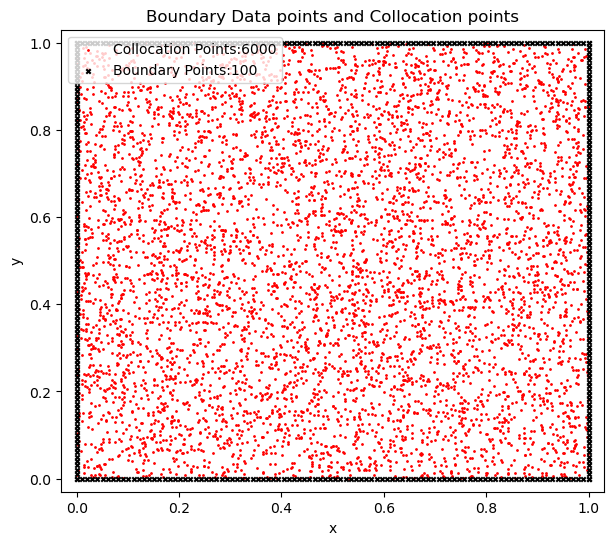

In [5]:
# 绘制训练点
def plot_train_points():
    # 随机种子确保可重复性
    torch.manual_seed(9)

    # 内部点随机采样
    num_samples_in = 6000
    x_in = torch.rand(num_samples_in, 1) * L  # 范围 [0, 1]
    y_in = torch.rand(num_samples_in, 1) * W  # 范围 [0, 1]

    # 边界点随机采样
    num_samples_bc = 100
    # 上边界和下边界
    x_bc_top = torch.linspace(0, L, num_samples_bc).unsqueeze(1)
    y_bc_top = torch.full_like(x_bc_top, W)

    x_bc_bottom = torch.linspace(0, L, num_samples_bc).unsqueeze(1)
    y_bc_bottom = torch.full_like(x_bc_bottom, 0)

    # 左边界和右边界
    y_bc_left = torch.linspace(0, W, num_samples_bc).unsqueeze(1)
    x_bc_left = torch.full_like(y_bc_left, 0)

    y_bc_right = torch.linspace(0, W, num_samples_bc).unsqueeze(1)
    x_bc_right = torch.full_like(y_bc_right, L)

    # 合并边界点
    x_bc = torch.cat([x_bc_top, x_bc_bottom, x_bc_left, x_bc_right], dim=0)
    y_bc = torch.cat([y_bc_top, y_bc_bottom, y_bc_left, y_bc_right], dim=0)

    # 绘图
    plt.figure(figsize=(7, 6))
    plt.scatter(x_in, y_in, color='red', s=1, label=f'Collocation Points:{num_samples_in}')  # 内部点
    plt.scatter(x_bc, y_bc, color='black', s=10, marker='x', label=f'Boundary Points:{num_samples_bc}')  # 边界点
    plt.title('Boundary Data points and Collocation points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.grid(True)
    plt.xlim(-0.03, 1.03)  # x轴范围略微扩展，避免边界点被遮挡
    plt.ylim(-0.03, 1.03)  # y轴范围略微扩展，避免边界点被遮挡
    # plt.savefig('figures/points.png', dpi=300)
    plt.show()

plot_train_points()

In [6]:
from torch.optim.lr_scheduler import StepLR
def train(model, optimizer, num_epochs = 50000):
    losses = []
    scheduler = StepLR(optimizer, step_size=2000, gamma=0.8)
    model.to(device)
    torch.manual_seed(9)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        optimizer.zero_grad()

        # 内部点随机采样
        num_samples_in = 3000
        x_in = (torch.rand(num_samples_in, 1)*L).to(device)
        y_in = (torch.rand(num_samples_in, 1)*W).to(device)
        x_in.requires_grad = True
        y_in.requires_grad = True

        # 物理损失（内部）
        f_loss = physics_loss(model, x_in, y_in)

        # 边界点随机采样
        num_sample_bc = 500
        y_bc = (torch.rand(num_sample_bc, 1)*W).to(device) # 两侧边界对称着随机取点
        x_bc = (torch.rand(num_sample_bc, 1)*L).to(device)
        bc_loss = boundary_loss(model, x_bc, y_bc)

        # 总损失
        loss = f_loss + bc_loss
        loss.backward()
        optimizer.step()
        scheduler.step() # 更新学习率

        # 记录损失
        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

### 训练部分

In [7]:
# 初始化模型和优化器
model = PINN_demo2()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 训练模型
losses = train(model, optimizer, 60000)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, MODEL_PATH)
print("Model training completed and saved!")

Training:   0%|          | 9/60000 [00:03<4:40:29,  3.56it/s] 

Epoch 0, Loss: 0.7339073419570923


Training:   2%|▏         | 1009/60000 [00:17<13:27, 73.02it/s]

Epoch 1000, Loss: 0.11027796566486359


Training:   3%|▎         | 2013/60000 [00:30<13:28, 71.70it/s]

Epoch 2000, Loss: 0.09659872949123383


Training:   5%|▌         | 3011/60000 [00:43<11:55, 79.63it/s]

Epoch 3000, Loss: 0.08735057711601257


Training:   7%|▋         | 4013/60000 [00:57<12:32, 74.37it/s]

Epoch 4000, Loss: 0.08755730092525482


Training:   8%|▊         | 5012/60000 [01:11<12:36, 72.65it/s]

Epoch 5000, Loss: 0.08159317076206207


Training:  10%|█         | 6011/60000 [01:24<11:40, 77.05it/s]

Epoch 6000, Loss: 0.07291607558727264


Training:  12%|█▏        | 7015/60000 [01:38<12:24, 71.15it/s]

Epoch 7000, Loss: 0.0687701553106308


Training:  13%|█▎        | 8008/60000 [01:51<11:10, 77.50it/s]

Epoch 8000, Loss: 0.06994571536779404


Training:  15%|█▌        | 9013/60000 [02:04<10:46, 78.89it/s]

Epoch 9000, Loss: 0.06455200165510178


Training:  17%|█▋        | 10013/60000 [02:17<10:32, 79.09it/s]

Epoch 10000, Loss: 0.0568457692861557


Training:  18%|█▊        | 11011/60000 [02:31<11:30, 70.93it/s]

Epoch 11000, Loss: 0.04823495075106621


Training:  20%|██        | 12011/60000 [02:44<11:45, 68.00it/s]

Epoch 12000, Loss: 0.05126091465353966


Training:  22%|██▏       | 13015/60000 [02:57<10:18, 75.98it/s]

Epoch 13000, Loss: 0.045956000685691833


Training:  23%|██▎       | 14011/60000 [03:11<09:59, 76.65it/s]

Epoch 14000, Loss: 0.041866667568683624


Training:  25%|██▌       | 15016/60000 [03:24<09:24, 79.66it/s]

Epoch 15000, Loss: 0.04088035598397255


Training:  27%|██▋       | 16011/60000 [03:37<10:20, 70.94it/s]

Epoch 16000, Loss: 0.038559362292289734


Training:  28%|██▊       | 17014/60000 [03:49<08:13, 87.17it/s]

Epoch 17000, Loss: 0.03984847292304039


Training:  30%|███       | 18012/60000 [04:01<08:58, 77.93it/s]

Epoch 18000, Loss: 0.03679520636796951


Training:  32%|███▏      | 19013/60000 [04:14<09:10, 74.51it/s]

Epoch 19000, Loss: 0.03501850739121437


Training:  33%|███▎      | 20010/60000 [04:27<08:27, 78.78it/s]

Epoch 20000, Loss: 0.03309841826558113


Training:  35%|███▌      | 21009/60000 [04:42<10:35, 61.40it/s]

Epoch 21000, Loss: 0.033400047570466995


Training:  37%|███▋      | 22013/60000 [04:55<08:09, 77.60it/s]

Epoch 22000, Loss: 0.030122675001621246


Training:  38%|███▊      | 23015/60000 [05:09<08:27, 72.94it/s]

Epoch 23000, Loss: 0.02357453480362892


Training:  40%|████      | 24010/60000 [05:22<06:55, 86.62it/s]

Epoch 24000, Loss: 0.026267288252711296


Training:  42%|████▏     | 25017/60000 [05:34<06:32, 89.09it/s]

Epoch 25000, Loss: 0.030423952266573906


Training:  43%|████▎     | 26009/60000 [05:46<07:43, 73.36it/s]

Epoch 26000, Loss: 0.02956511825323105


Training:  45%|████▌     | 27010/60000 [05:58<06:28, 84.93it/s]

Epoch 27000, Loss: 0.0276783499866724


Training:  47%|████▋     | 28015/60000 [06:10<06:22, 83.57it/s]

Epoch 28000, Loss: 0.033133748918771744


Training:  48%|████▊     | 29015/60000 [06:21<05:31, 93.40it/s]

Epoch 29000, Loss: 0.02835426665842533


Training:  50%|█████     | 30015/60000 [06:33<05:37, 88.74it/s]

Epoch 30000, Loss: 0.035202525556087494


Training:  52%|█████▏    | 31011/60000 [06:46<06:52, 70.27it/s]

Epoch 31000, Loss: 0.028418488800525665


Training:  53%|█████▎    | 32007/60000 [06:59<06:13, 75.04it/s]

Epoch 32000, Loss: 0.028181128203868866


Training:  55%|█████▌    | 33014/60000 [07:13<06:02, 74.43it/s]

Epoch 33000, Loss: 0.026735622435808182


Training:  57%|█████▋    | 34009/60000 [07:26<05:35, 77.45it/s]

Epoch 34000, Loss: 0.023480046540498734


Training:  58%|█████▊    | 35012/60000 [07:39<05:55, 70.31it/s]

Epoch 35000, Loss: 0.027974681928753853


Training:  60%|██████    | 36013/60000 [07:52<04:55, 81.24it/s]

Epoch 36000, Loss: 0.02763635665178299


Training:  62%|██████▏   | 37013/60000 [08:05<04:56, 77.57it/s]

Epoch 37000, Loss: 0.02599402517080307


Training:  63%|██████▎   | 38010/60000 [08:19<04:57, 73.97it/s]

Epoch 38000, Loss: 0.025157859548926353


Training:  65%|██████▌   | 39012/60000 [08:32<04:35, 76.26it/s]

Epoch 39000, Loss: 0.025139473378658295


Training:  67%|██████▋   | 40013/60000 [08:44<04:25, 75.38it/s]

Epoch 40000, Loss: 0.024579457938671112


Training:  68%|██████▊   | 41009/60000 [08:57<04:00, 78.92it/s]

Epoch 41000, Loss: 0.020620888099074364


Training:  70%|███████   | 42015/60000 [09:10<03:51, 77.71it/s]

Epoch 42000, Loss: 0.024833567440509796


Training:  72%|███████▏  | 43010/60000 [09:23<03:34, 79.29it/s]

Epoch 43000, Loss: 0.023671481758356094


Training:  73%|███████▎  | 44012/60000 [09:36<03:15, 81.81it/s]

Epoch 44000, Loss: 0.020718738436698914


Training:  75%|███████▌  | 45011/60000 [09:48<03:10, 78.56it/s]

Epoch 45000, Loss: 0.02322089858353138


Training:  77%|███████▋  | 46008/60000 [10:01<02:59, 77.99it/s]

Epoch 46000, Loss: 0.023977963253855705


Training:  78%|███████▊  | 47016/60000 [10:14<02:42, 79.74it/s]

Epoch 47000, Loss: 0.01632256805896759


Training:  80%|████████  | 48014/60000 [10:27<02:29, 80.37it/s]

Epoch 48000, Loss: 0.023633921518921852


Training:  82%|████████▏ | 49012/60000 [10:40<02:14, 81.86it/s]

Epoch 49000, Loss: 0.029806148260831833


Training:  83%|████████▎ | 50010/60000 [10:53<02:10, 76.79it/s]

Epoch 50000, Loss: 0.029901495203375816


Training:  85%|████████▌ | 51015/60000 [11:06<01:47, 83.48it/s]

Epoch 51000, Loss: 0.022239308804273605


Training:  87%|████████▋ | 52014/60000 [11:19<01:53, 70.63it/s]

Epoch 52000, Loss: 0.024127883836627007


Training:  88%|████████▊ | 53011/60000 [11:32<01:31, 76.20it/s]

Epoch 53000, Loss: 0.02604631893336773


Training:  90%|█████████ | 54011/60000 [11:45<01:17, 77.53it/s]

Epoch 54000, Loss: 0.024129239842295647


Training:  92%|█████████▏| 55015/60000 [11:58<01:02, 79.69it/s]

Epoch 55000, Loss: 0.019285302609205246


Training:  93%|█████████▎| 56017/60000 [12:11<00:48, 81.56it/s]

Epoch 56000, Loss: 0.026602528989315033


Training:  95%|█████████▌| 57013/60000 [12:24<00:37, 79.08it/s]

Epoch 57000, Loss: 0.02728278748691082


Training:  97%|█████████▋| 58014/60000 [12:37<00:26, 75.63it/s]

Epoch 58000, Loss: 0.024277647957205772


Training:  98%|█████████▊| 59011/60000 [12:50<00:12, 80.26it/s]

Epoch 59000, Loss: 0.02787253074347973


Training: 100%|██████████| 60000/60000 [13:02<00:00, 76.66it/s]

Model training completed and saved!


loss = 0.020785119384527206


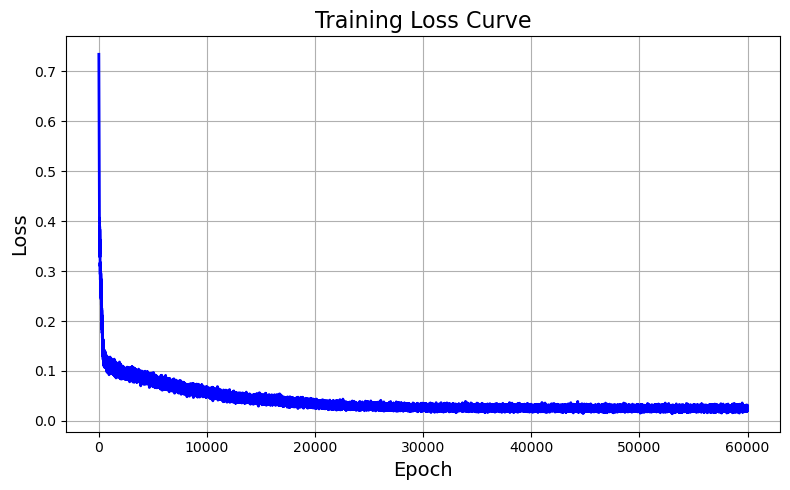

In [8]:
def plot_loss(losses):
    print(f'loss = {losses[-1]}')
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='blue', lw=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training Loss Curve', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('figures/loss_curve_demo2_1.png', dpi=300)
    plt.show()

plot_loss(losses)

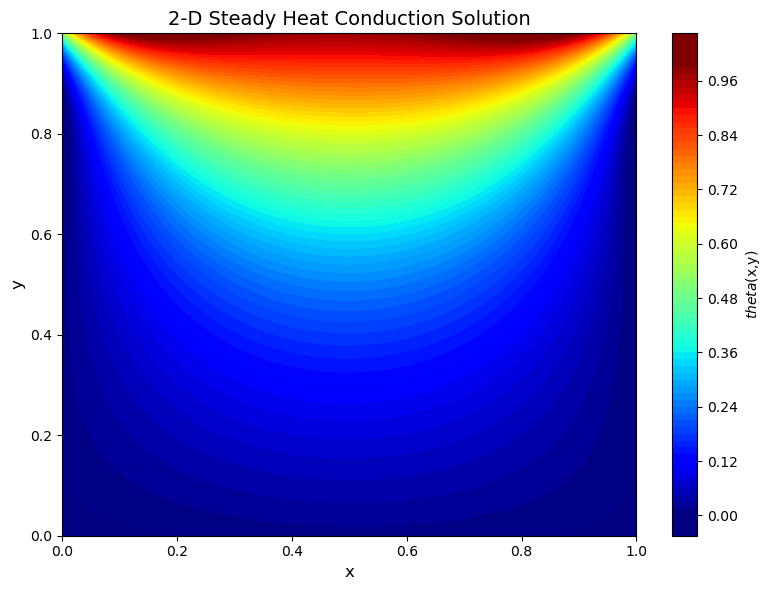

In [9]:
# PINN结果绘制二维等高图
def plot_solution_contour(model):
    # 创建(x,y)网格
    x = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
    y = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')

    # 将 X 和 Y拉平
    x_flat = X.reshape(-1, 1).to(device)
    y_flat = Y.reshape(-1, 1).to(device)

    with torch.no_grad():
        theta_pred = model(x_flat, y_flat).cpu().numpy().reshape(100, 100)

    # 绘制二维等高线图
    plt.figure(figsize=(8,6))
    plt.contourf(X.cpu().numpy(), Y.cpu().numpy(), theta_pred, 100, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(label=f'$theta$(x,y)')

    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('2-D Steady Heat Conduction Solution', fontsize=14)

    plt.tight_layout()
    plt.savefig('figures/loss_curve_demo2_2.png', dpi=300)
    plt.show()

plot_solution_contour(model)
    

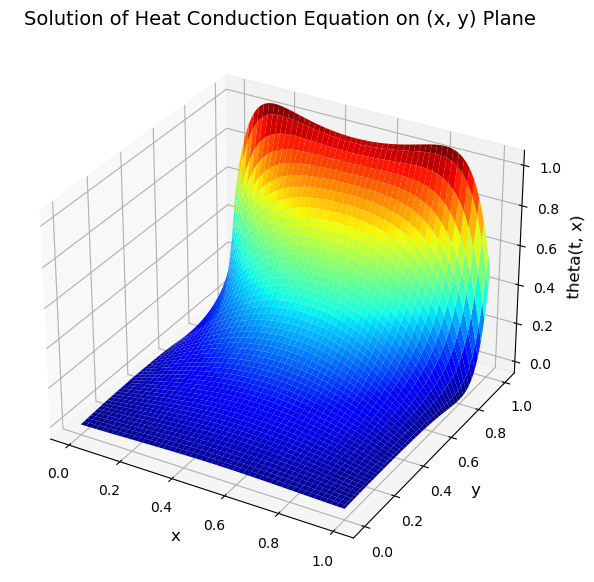

In [10]:
# 绘制整个（x, t) 平面的解
def plot_solution_3d(model):
    # 创建 (x, t) 网格
    x = torch.linspace(0, 1,100).unsqueeze(1).to(device)
    y = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
 
    # 将 X和T 拉平，方便模型预测
    x_flat = X.reshape(-1, 1).to(device)
    y_flat = Y.reshape(-1, 1).to(device)

    with torch.no_grad():
        u_pred = model(x_flat, y_flat).cpu().numpy().reshape(100, 100)

    # 绘制三维曲面图
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.cpu().numpy(), Y.cpu().numpy(), u_pred, cmap='jet') # 可选viridis

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('theta(t, x)', fontsize=12)
    ax.set_title('Solution of Heat Conduction Equation on (x, y) Plane', fontsize=14)
    # plt.savefig('figures/loss_curve_demo2_3.png', dpi=300)
    plt.show()

plot_solution_3d(model)

## 2. 解析解法

In [11]:
def analytical_solution(x, y, terms=100):
    """
    terms: 傅里叶展开的项数
    """
    theta = np.zeros_like(x)
    for n in range(1, terms+1):
        C_n = 2 * ((-1)**(n + 1) + 1) / (n * np.pi * np.sinh(n * np.pi * W / L))

        theta += C_n * np.sin(n * np.pi * x / L) * np.sinh(n * np.pi * y / L)

    # # 改进溢出问题
    # theta = np.zeros_like(x)
    
    # for n in range(1, terms+1):
    #     n_pi = n * np.pi
    #     n_pi_L = n_pi / L
    #     n_pi_W = n_pi * W / L
        
    #     # 预先计算 sinh 项，避免大数计算
    #     try:
    #         sinh_term = np.sinh(n_pi_W)
    #         if np.isinf(sinh_term):
    #             continue
                
    #         C_n = 2 * ((-1)**(n + 1) + 1) / (n_pi * sinh_term)
    #         theta += C_n * np.sin(n_pi_L * x) * np.sinh(n_pi_L * y)
    #     except:
    #         break

    # 为了解决NAN值
    # theta[np.isnan(theta)] = 0  # 将 NaN 替换为 0
    # theta[np.isinf(theta)] = 0  # 将 inf 替换为 0
    
    return np.nan_to_num(theta, 0)

# def analytical_solution(x, y, terms=100):
#     """
#     x, y: 二维网格点
#     terms: 傅里叶展开的项数
#     """
#     theta = np.zeros_like(x)

#     def sinh_stable(x):
#         threshold = 700  # 防止溢出
#         return np.where(x > threshold, 0.5 * np.exp(x), np.sinh(x))

#     for n in range(1, terms + 1):
#         C_n = 2 * ((-1) ** (n + 1) + 1) / (n * np.pi * sinh_stable(n * np.pi * W / L))
        
#         # 放宽屏蔽条件
#         if np.abs(C_n) < 1e-20 or np.isinf(C_n):
#             print(f"Skipping term n={n}, C_n={C_n}")
#             continue

#         # 调试：计算每一项对结果的贡献
#         contribution = C_n * np.max(np.abs(sinh_stable(n * np.pi * y / L)))
#         if np.abs(contribution) < 1e-20:  # 基于贡献值跳过
#             print(f"Skipping term n={n}, contribution={contribution}")
#             continue

#         # 正常计算
#         theta += C_n * np.sin(n * np.pi * x / L) * sinh_stable(n * np.pi * y / L)

#     return theta
    



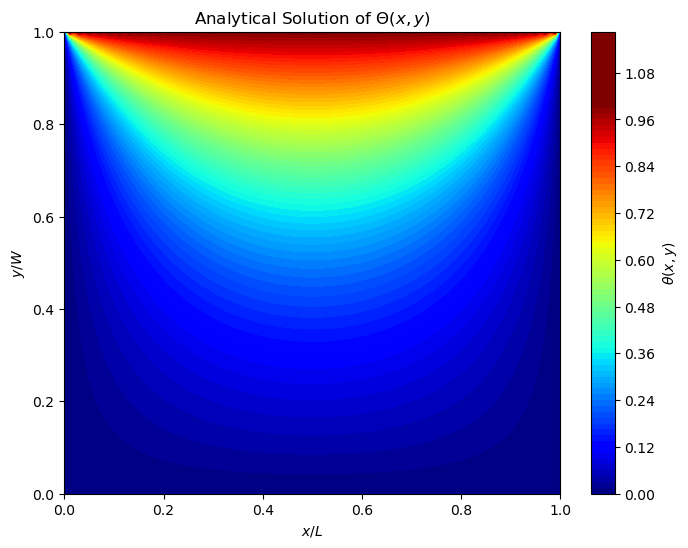

In [12]:
def plot_solution_analytical():
    # 生成网格点
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)

    # 计算解析解
    
    theta_analytical = analytical_solution(X, Y, 100)

    # 绘制解析解的二维温度场分布
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, theta_analytical, levels=100, cmap='jet', vmin=0, vmax=1)
    
    plt.colorbar(label=r'$\theta(x, y)$')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/W$')
    plt.title('Analytical Solution of $\Theta(x, y)$')
    # plt.savefig('figures/loss_curve_demo2_analy_solut.png', dpi=300)
    plt.show()

plot_solution_analytical()

## 3. 数值解法

In [13]:
# 有限差分法解决
def numerical_solution(Nx=99, Ny=99):
    # Nx = Ny = 99
    dx = L / (Nx+1)
    dy = W / (Ny+1)
    max_iter = 6000
    tolerance = 1e-5

    # 初始化温度场
    T = np.zeros((Nx+1, Ny+1))
    T[:, 0] = 0  # 底部边界
    T[:, Ny] = 1  # 顶部边界
    T[0, :] = 0  # 左边界.
    T[Nx, :] = 0  # 右边界

    for iter in range(max_iter):
        T_old = T.copy()
        # 只需要更新内部节点
        T[1: Nx, 1:Ny] = (T[0: Nx-1, 1:Ny] + T[2: Nx+1, 1:Ny] + T[1: Nx, 2:Ny+1] + T[1: Nx, 0:Ny-1])/4

        max_change = np.max(np.abs(T - T_old))
        # print(f'Error {iter+1}: {max_change}')

        if max_change < tolerance:
            print(f'Iteration convergence, number of iterations: {iter + 1}')
            break
    else:
        print('Iteration did not converge!')

    return T.T, Nx, Ny




Iteration convergence, number of iterations: 5991


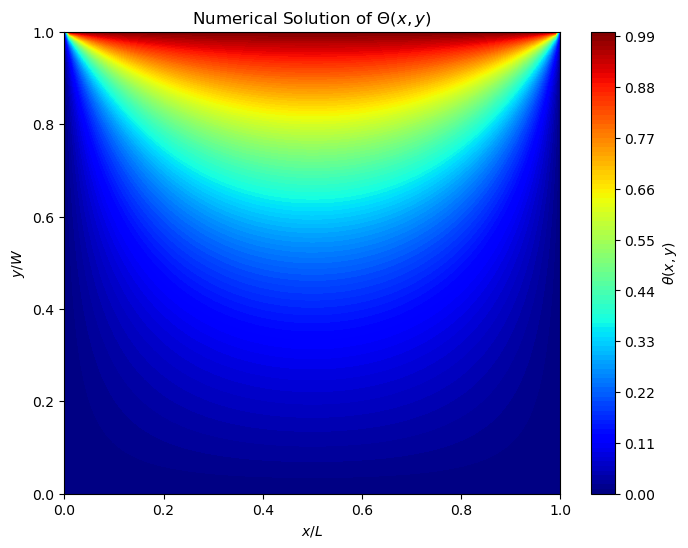

In [14]:
# 绘制数值解法FDM温度分布图
def plot_solution_numerical():
    T, Nx, Ny = numerical_solution()
    plt.figure(figsize=(8,6))
    x = np.linspace(0, L, Nx+1)
    y = np.linspace(0, W, Ny+1)
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, T, cmap='jet',levels=100 , vmin=0, vmax=1)
    plt.colorbar(label=r'$\theta(x, y)$')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/W$')
    plt.title('Numerical Solution of $\Theta(x, y)$')
    # plt.savefig('figures/loss_curve_demo2_num_solu.png', dpi=300)
    plt.show()

plot_solution_numerical()

## 4. 数据误差分析部分

Iteration convergence, number of iterations: 5991
MSE of Numerical Solution: 9.94e-05
MSE of PINN Solution: 2.81e-04


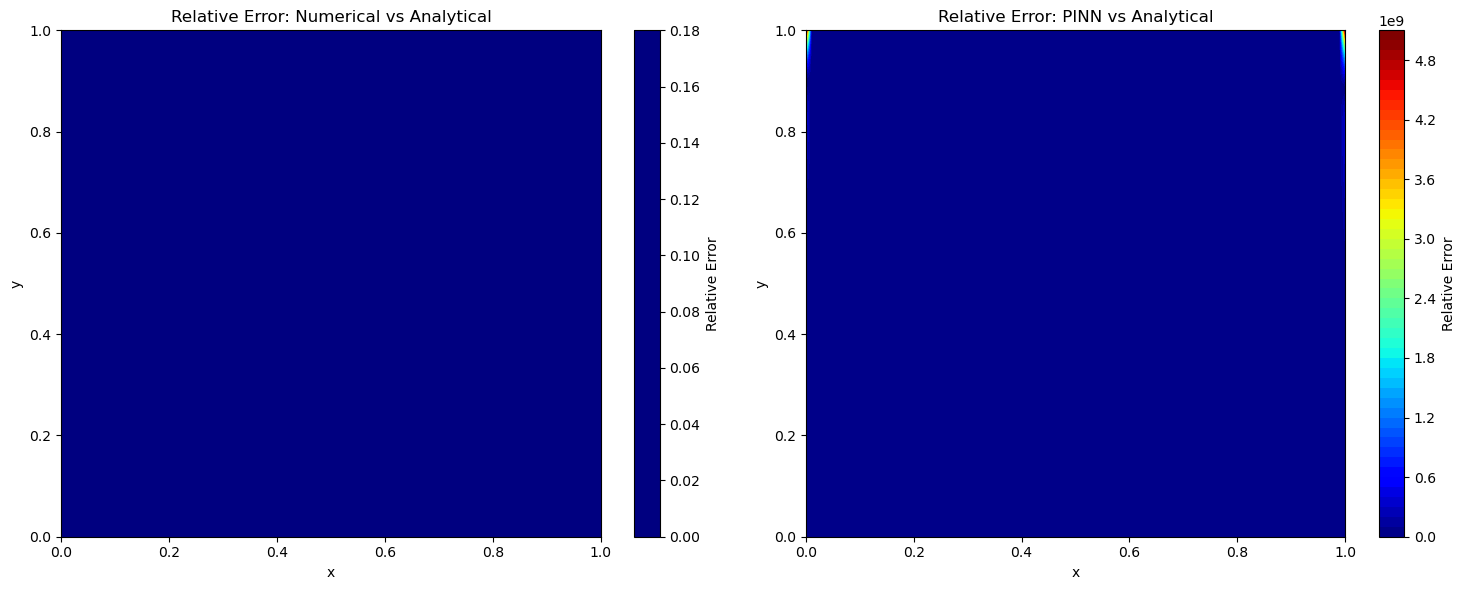

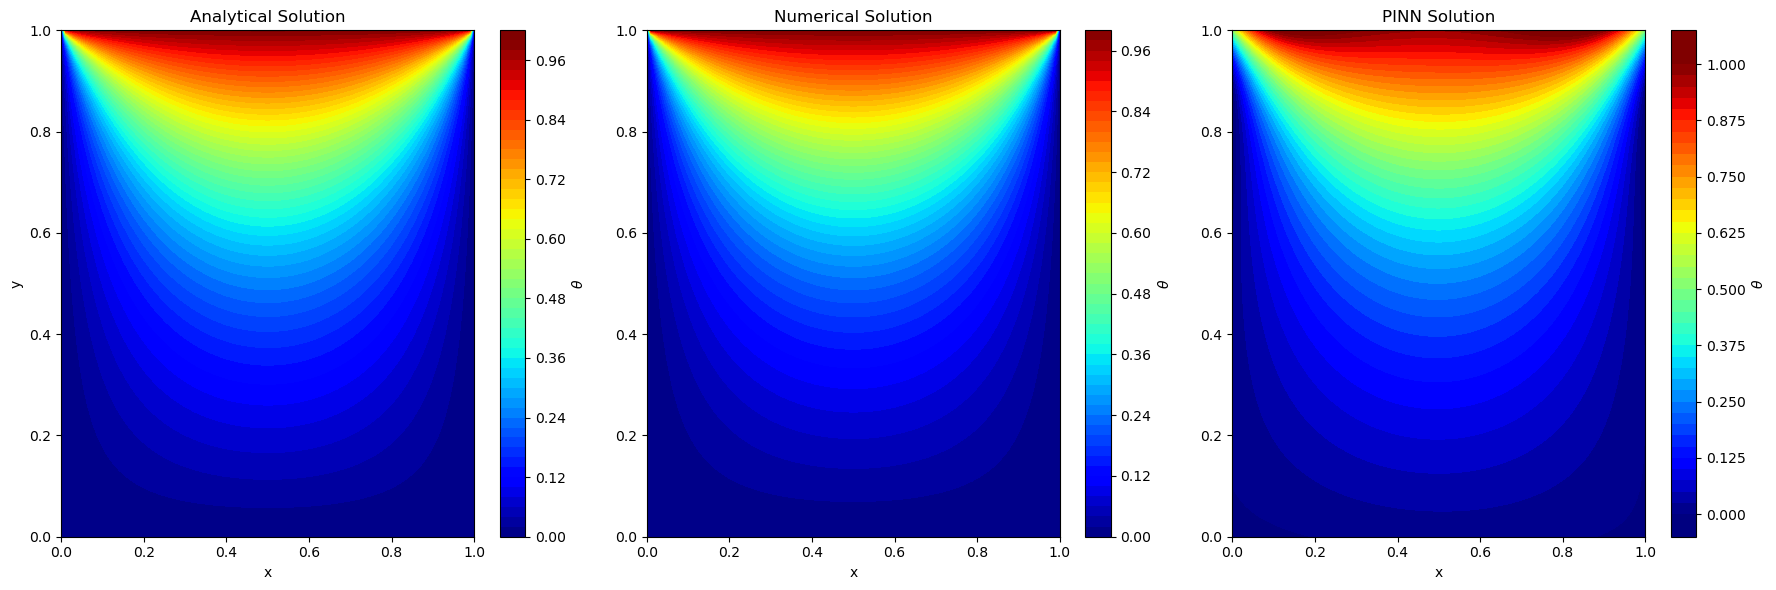

In [15]:
def solution_compare(model):
    # 统一网格点数
    n_points = 100  
    x = np.linspace(0, L, n_points)
    y = np.linspace(0, W, n_points)
    X, Y = np.meshgrid(x, y)  # 注意meshgrid的顺序
    
    # 计算PINN解
    x_tensor = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    
    with torch.no_grad():
        theta_pred = model(x_tensor, y_tensor).cpu().numpy().reshape(X.shape)
    
    # 计算解析解
    theta_analy = analytical_solution(X, Y, 200)
    
    # 计算数值解（确保使用相同的网格点数）
    theta_numerical, _, _ = numerical_solution(n_points-1, n_points-1)
    
    # 确保所有解的形状一致
    assert theta_analy.shape == theta_numerical.shape == theta_pred.shape
    
    # 计算相对误差而不是绝对误差
    error_numerical = np.abs(theta_numerical - theta_analy) / (np.abs(theta_analy) + 1e-10)
    error_pinn = np.abs(theta_pred - theta_analy) / (np.abs(theta_analy) + 1e-10)
    # 使用归一化的相对误差
    # theta_max = np.max(np.abs(theta_analy))
    # error_numerical = np.abs(theta_numerical.T - theta_analy) / theta_max
    # error_pinn = np.abs(theta_pred - theta_analy) / theta_max
    
    # 计算均方误差
    mse_numerical = np.mean((theta_numerical - theta_analy) ** 2)
    mse_pinn = np.mean((theta_pred - theta_analy) ** 2)
    
    print(f'MSE of Numerical Solution: {mse_numerical:.2e}')
    print(f'MSE of PINN Solution: {mse_pinn:.2e}')
    
    # 绘制相对误差分布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 使用相同的颜色范围便于比较
    vmin = min(error_numerical.min(), error_pinn.min())
    vmax = max(error_numerical.max(), error_pinn.max())
    # vmin = 0
    # vmax = max(np.percentile(error_numerical, 95), np.percentile(error_pinn, 95))  # 使用95百分位数作为最大值
    
    im1 = ax1.contourf(X, Y, error_numerical, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(im1, ax=ax1, label='Relative Error')
    # plt.colorbar(im1, ax=ax1, label='Normalized Error')
    ax1.set_title('Relative Error: Numerical vs Analytical')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    im2 = ax2.contourf(X, Y, error_pinn, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, ax=ax2, label='Relative Error')
    # plt.colorbar(im2, ax=ax2, label='Normalized Error')
    ax2.set_title('Relative Error: PINN vs Analytical')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    plt.tight_layout()
    # plt.savefig('figures/loss_curve_demo2_ralativeMSE.png', dpi=300)
    plt.show()
    
    # 额外绘制解的分布图以便比较
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    im1 = ax1.contourf(X, Y, theta_analy, levels=50, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(im1, ax=ax1, label=r'$\theta$')
    ax1.set_title('Analytical Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    im2 = ax2.contourf(X, Y, theta_numerical, levels=50, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(im2, ax=ax2, label=r'$\theta$')
    ax2.set_title('Numerical Solution')
    ax2.set_xlabel('x')
    
    im3 = ax3.contourf(X, Y, theta_pred, levels=50, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(im3, ax=ax3, label=r'$\theta$')
    ax3.set_title('PINN Solution')
    ax3.set_xlabel('x')
    
    plt.tight_layout()
    # plt.savefig('figures/loss_curve_demo2_3soluts.png', dpi=300)
    plt.show()

solution_compare(model)

### 绘制固定坐标下的温度分布对比图

Iteration convergence, number of iterations: 5991


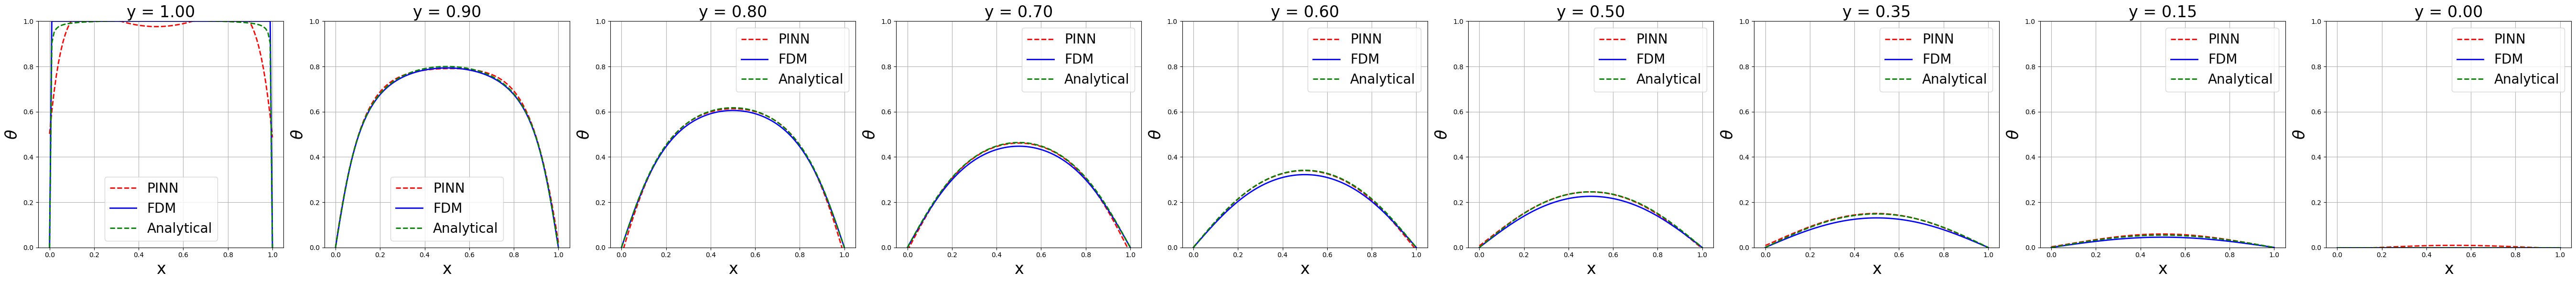

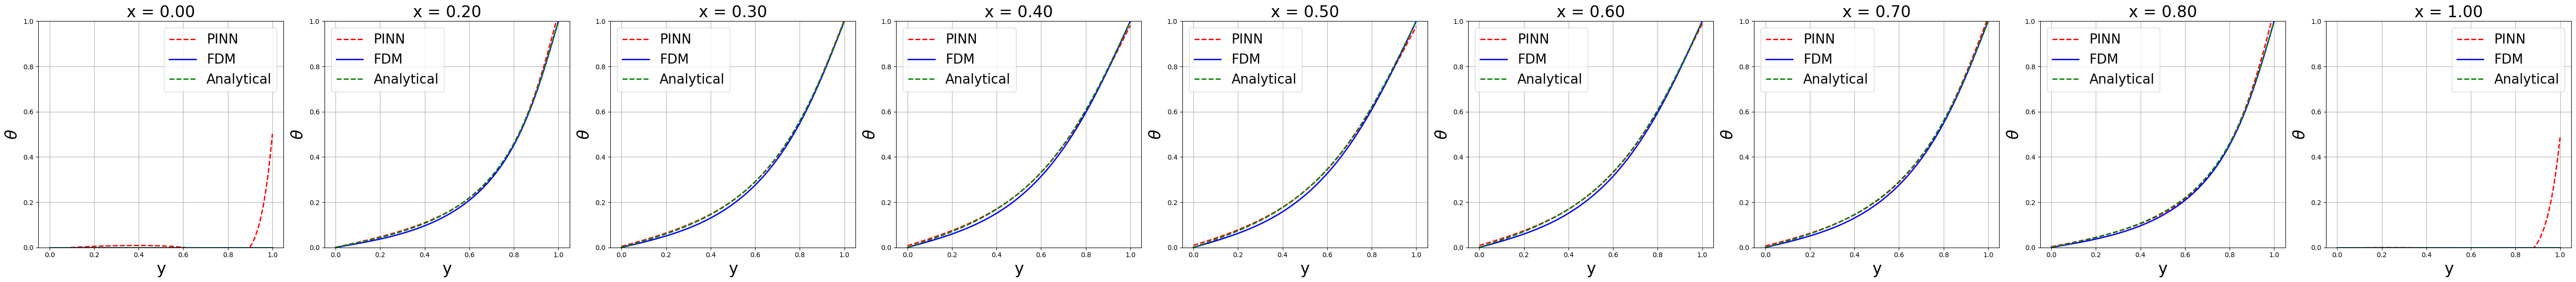

In [ ]:
def plot_temperature_profiles(model, n_points=100, y_positions=None, x_positions=None):
    """
    绘制固定坐标下的温度分布对比图
    
    Args:
        model: PINN模型
        n_points: 网格点数
        y_positions: 固定的y坐标位置列表
        x_positions: 固定的x坐标位置列表
    """
    x = np.linspace(0, L, n_points)
    y = np.linspace(0, W, n_points)
    X, Y = np.meshgrid(x, y)

    # PINN
    x_tensor = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        theta_pinn = model(x_tensor, y_tensor).cpu().numpy().reshape(X.shape)

    # 解析解
    theta_analy = analytical_solution(X, Y, 200)

    # 数值解
    theta_numerical, _, _ = numerical_solution(n_points-1, n_points-1)

    # 绘图
    if y_positions is not None:
        fig1, axes1 = plt.subplots(1, len(y_positions), figsize=(54,6))
        for i, y_pos in enumerate(y_positions):
            y_idx = np.abs(y - y_pos).argmin()  # 目标y_p再y数组中的最接近索引

            axes1[i].plot(x, theta_pinn[y_idx, :], 'r--', label='PINN', linewidth=2)
            axes1[i].plot(x, theta_numerical[y_idx, :], 'b-', label='FDM', linewidth=2)
            axes1[i].plot(x, theta_analy[y_idx, :], 'g--', label='Analytical', linewidth=2)

            axes1[i].set_xlabel('x', fontsize=24)
            axes1[i].set_ylabel(r'$\theta$', fontsize=24)
            axes1[i].set_title(f'y = {y_pos:.2f}', fontsize=24)
            axes1[i].grid(True)
            axes1[i].legend(fontsize=20)
            axes1[i].set_ylim(0, 1)

        plt.tight_layout()
        # plt.savefig('figures/loss_curve_demo2_aty_compare.png', dpi=300)
        plt.show()

    if x_positions is not None:
        fig2, axes2 = plt.subplots(1, len(x_positions), figsize=(54,6))
        for i, x_pos in enumerate(x_positions):
            x_idx = np.abs(x - x_pos).argmin()  # 目标y_p再y数组中的最接近索引

            axes2[i].plot(y, theta_pinn[:, x_idx], 'r--', label='PINN', linewidth=2)
            axes2[i].plot(y, theta_numerical[:, x_idx], 'b-', label='FDM', linewidth=2)
            axes2[i].plot(y, theta_analy[:, x_idx], 'g--', label='Analytical', linewidth=2)

            axes2[i].set_xlabel('y', fontsize=24)
            axes2[i].set_ylabel(r'$\theta$', fontsize=24)
            axes2[i].set_title(f'x = {x_pos:.2f}', fontsize=24)
            axes2[i].grid(True)
            axes2[i].legend(fontsize=20)
            axes2[i].set_ylim(0, 1)

        plt.tight_layout()
        # plt.savefig('figures/loss_curve_demo2_atx_compare.png', dpi=300)
        plt.show()


y_positions = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.35, 0.15, 0.0])
x_positions = np.array([0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0])

plot_temperature_profiles(model,n_points=100 , y_positions=y_positions, x_positions=x_positions)

In [17]:
import torch.onnx


# 定义一个用于导出 ONNX 的示例输入
example_input = torch.randn(1, 2).to(device)  # 输入的形状为 [batch_size, 2]

# 导出 ONNX 模型
onnx_path = "model/pinn_model_demo2.onnx"
torch.onnx.export(
    model.layer,  # 导出模型的核心网络结构
    example_input,  # 示例输入
    onnx_path,  # 保存的 ONNX 文件路径
    export_params=True,  # 导出训练好的权重
    opset_version=11,  # 使用的 ONNX opset 版本
    do_constant_folding=True,  # 是否进行常量折叠优化
    input_names=["input"],  # 输入节点的名称
    output_names=["output"],  # 输出节点的名称
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},  # 动态批量大小
)

print(f"Model has been exported to {onnx_path}")


Model has been exported to model/pinn_model_demo2.onnx
